In [1]:
import pandas as pd
from pandas import Timestamp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pycaret.regression import *
from sklearn.model_selection import TimeSeriesSplit

In [3]:
train = pd.read_csv("Data/train.csv", index_col = 0)
train['time'] = pd.to_datetime(train['time'])
train.shape

(848835, 5)

In [13]:
test = pd.read_csv("Data/test.csv", index_col = 0)
test['time'] = pd.to_datetime(test['time'])
test.shape

(2340, 4)

In [14]:
train.head()

,time,x,y,direction,congestion,month,day,day_of_week,is_weekend,hour,minute,sin_time,cos_time,road_id
row_id,,,,,,,,,,,,,,
0,1991-04-01,0,0,EB,70,4,1,0,False,0,0,0.0,1.0,00EB
1,1991-04-01,0,0,NB,49,4,1,0,False,0,0,0.0,1.0,00NB
2,1991-04-01,0,0,SB,24,4,1,0,False,0,0,0.0,1.0,00SB
3,1991-04-01,0,1,EB,18,4,1,0,False,0,0,0.0,1.0,01EB
4,1991-04-01,0,1,NB,60,4,1,0,False,0,0,0.0,1.0,01NB


In [15]:
test.head()

,time,x,y,direction
row_id,,,,
848835,1991-09-30 12:00:00,0,0,EB
848836,1991-09-30 12:00:00,0,0,NB
848837,1991-09-30 12:00:00,0,0,SB
848838,1991-09-30 12:00:00,0,1,EB
848839,1991-09-30 12:00:00,0,1,NB


In [7]:
test.time.min()

Timestamp('1991-09-30 12:00:00')

In [8]:
test.time.max()

Timestamp('1991-09-30 23:40:00')

# Generate added features

In [9]:
def generate_features(df):
    df['month'] = df.time.dt.month
    df['day'] = df.time.dt.day
    df['day_of_week'] = df.time.dt.day_of_week
    df['is_weekend'] = df['day_of_week'] >= 5
    df['hour'] = df.time.dt.hour
    df['minute'] = df.time.dt.minute

    n_minutes_1_day = 24*60
    df['sin_time'] = np.sin(2*np.pi*(df['hour'] * 60 + df['minute'])/n_minutes_1_day)
    df['cos_time'] = np.cos(2*np.pi*(df['hour'] * 60 + df['minute'])/n_minutes_1_day)

    df['road_id'] = df['x'].astype(str) + df['y'].astype(str) + df['direction']
    
    congestion_wide = df.pivot(index = ['time'], columns = 'road_id', values = 'congestion')
    for shift in [1, 2, 3, 72, 504]:
        shifted_data = congestion_wide.shift(shift).reset_index().melt(id_vars = ['time'])
        shifted_data.columns = ['time', 'road_id', f'congestion_t{shift}']
        df = df.merge(shifted_data, on = ['time', 'road_id'])
        
    return df

In [12]:
# Get predictions in a rolling fashion in order to get the previous timestamps -> we can get predictions in chunks of 65 samples (number of rows)
def generate_predictions(model, train_data, test_data):# all_data, timestamps_to_predict):
    
    if 'congestion' not in test_data.columns:
        test_data['congestion'] = np.nan
    
    output_data = pd.concat([train_data, test_data]).copy()
    timestamps_to_predict = test_data.time.unique()
    
    for timestamp in timestamps_to_predict:
        print(f"Predicting timestamp: {timestamp}")
        
        congestion_wide = output_data.pivot(index = ['time'], columns = 'road_id', values = 'congestion')
        for shift in [1, 2, 3, 72, 504]:
            shifted_data = congestion_wide.shift(shift).reset_index().melt(id_vars = ['time'])
            shifted_data.columns = ['time', 'road_id', f'congestion_t{shift}']
            output_data = output_data.drop(f'congestion_t{shift}', axis = 1)
            output_data = output_data.merge(shifted_data, on = ['time', 'road_id'])
        
        input_data = output_data[output_data.time == timestamp]
        predictions = predict_model(model, data = input_data)
        output_data.loc[input_data.index, 'congestion'] = predictions.Label.round(0)
    
    test_predictions = output_data[output_data.time >= test_data.time.min()]
    return test_predictions

In [10]:
train_data = generate_features(train)
test_data = generate_features(test)

In [ ]:
train_data

In [12]:
test_data

,time,x,y,direction,congestion,month,day,day_of_week,is_weekend,hour,minute,sin_time,cos_time,road_id,congestion_t1,congestion_t2,congestion_t3,congestion_t72,congestion_t504
0,1991-09-30 12:00:00,0,0,EB,NaN,9,30,0,False,12,0,1.224647e-16,-1.000000,00EB,NaN,NaN,NaN,NaN,NaN
1,1991-09-30 12:00:00,0,0,NB,NaN,9,30,0,False,12,0,1.224647e-16,-1.000000,00NB,NaN,NaN,NaN,NaN,NaN
2,1991-09-30 12:00:00,0,0,SB,NaN,9,30,0,False,12,0,1.224647e-16,-1.000000,00SB,NaN,NaN,NaN,NaN,NaN
3,1991-09-30 12:00:00,0,1,EB,NaN,9,30,0,False,12,0,1.224647e-16,-1.000000,01EB,NaN,NaN,NaN,NaN,NaN
4,1991-09-30 12:00:00,0,1,NB,NaN,9,30,0,False,12,0,1.224647e-16,-1.000000,01NB,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2335,1991-09-30 23:40:00,2,3,NB,NaN,9,30,0,False,23,40,-8.715574e-02,0.996195,23NB,NaN,NaN,NaN,NaN,NaN
2336,1991-09-30 23:40:00,2,3,NE,NaN,9,30,0,False,23,40,-8.715574e-02,0.996195,23NE,NaN,NaN,NaN,NaN,NaN
2337,1991-09-30 23:40:00,2,3,SB,NaN,9,30,0,False,23,40,-8.715574e-02,0.996195,23SB,NaN,NaN,NaN,NaN,NaN
2338,1991-09-30 23:40:00,2,3,SW,NaN,9,30,0,False,23,40,-8.715574e-02,0.996195,23SW,NaN,NaN,NaN,NaN,NaN


In [13]:
train['time'].min(), train['time'].max()

(Timestamp('1991-04-01 00:00:00'), Timestamp('1991-09-30 11:40:00'))

In [14]:
train_data.shape

(848835, 19)

In [15]:
test_data.shape

(2340, 19)

# Run experiment

In [16]:
exp = setup(data = train_data, target = 'congestion', session_id=123, 
            categorical_features = ['direction', 'road_id'], 
            numeric_features = ['x', 'y', 'month', 'day', 'day_of_week', 'is_weekend', 'hour', 'minute', 'sin_time', 'cos_time', 'congestion_t1', 'congestion_t2', 'congestion_t3', 'congestion_t72', 'congestion_t504'], 
            silent = True, 
            use_gpu = True,
            fold_strategy = 'timeseries') 

,Description,Value
0,session_id,123
1,Target,congestion
2,Original Data,"(848835, 19)"
3,Missing Values,1
4,Numeric Features,15
5,Categorical Features,2
6,Ordinal Features,0
7,High Cardinality Features,0
8,High Cardinality Method,None
9,Transformed Train Set,"(594184, 127)"


In [17]:
top5_models = compare_models(n_select = 5, include = ['et', 'lightgbm', 'rf', 'lr', 'ridge'], fold = 4)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,5.9079,73.2571,8.5588,0.7404,0.2370,0.1584,666.9450
lightgbm,Light Gradient Boosting Machine,5.9900,73.2879,8.5608,0.7403,0.2387,0.1609,6.5600
rf,Random Forest Regressor,6.0201,75.3851,8.6823,0.7328,0.2397,0.1616,375.7925
lr,Linear Regression,6.1649,76.3800,8.7395,0.7293,0.2424,0.1647,2.6500
ridge,Ridge Regression,6.1650,76.3800,8.7395,0.7293,0.2424,0.1647,0.4675


In [18]:
for i, model in enumerate(top5_models):
    save_model(model, f'Models/PycaretRegressionTop{i}')

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved


# Predict - top model

In [16]:
model = create_model('lightgbm', fold = 4)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,5.9923,73.4484,8.5702,0.7395,0.2388,0.1598
1,5.9900,73.6644,8.5828,0.7388,0.2357,0.1595
2,6.0151,73.7186,8.5860,0.7384,0.2411,0.1643
3,5.9624,72.3206,8.5042,0.7444,0.2394,0.1601
Mean,5.9900,73.2880,8.5608,0.7403,0.2387,0.1609
SD,0.0187,0.5676,0.0332,0.0024,0.0020,0.0020


In [23]:
final_model = finalize_model(model)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              device='gpu', importance_type='split', learning_rate=0.1,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
              objective=None, random_state=123, reg_alpha=0.0, reg_lambda=0.0,
              silent='warn', subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [109]:
test_predictions = generate_predictions(final_model, train_data, test_data)

Predicting timestamp: 1991-09-30T12:00:00.000000000
Predicting timestamp: 1991-09-30T12:20:00.000000000
Predicting timestamp: 1991-09-30T12:40:00.000000000
Predicting timestamp: 1991-09-30T13:00:00.000000000
Predicting timestamp: 1991-09-30T13:20:00.000000000
Predicting timestamp: 1991-09-30T13:40:00.000000000
Predicting timestamp: 1991-09-30T14:00:00.000000000
Predicting timestamp: 1991-09-30T14:20:00.000000000
Predicting timestamp: 1991-09-30T14:40:00.000000000
Predicting timestamp: 1991-09-30T15:00:00.000000000
Predicting timestamp: 1991-09-30T15:20:00.000000000
Predicting timestamp: 1991-09-30T15:40:00.000000000
Predicting timestamp: 1991-09-30T16:00:00.000000000
Predicting timestamp: 1991-09-30T16:20:00.000000000
Predicting timestamp: 1991-09-30T16:40:00.000000000
Predicting timestamp: 1991-09-30T17:00:00.000000000
Predicting timestamp: 1991-09-30T17:20:00.000000000
Predicting timestamp: 1991-09-30T17:40:00.000000000
Predicting timestamp: 1991-09-30T18:00:00.000000000
Predicting t

In [110]:
test_predictions

,row_id,congestion
0,848835,56
1,848836,41
2,848837,49
3,848838,24
4,848839,66
...,...,...
2335,851170,65
2336,851171,29
2337,851172,70
2338,851173,18


In [111]:
test_predictions.to_csv("Submissions/pycaret_lightgbm_rounded.csv",  index_label = 'row_id')

In [17]:
evaluate_model(model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

# Blend top 5 models

In [19]:
blended_model = blend_models(top5_models)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,5.9887,73.2818,8.5605,0.7401,0.2391,0.1626
1,6.0188,73.9169,8.5975,0.7376,0.2381,0.1611
2,5.9555,72.6607,8.5241,0.7414,0.2401,0.1599
3,5.9242,71.8476,8.4763,0.7438,0.2306,0.1560
4,5.9793,73.5885,8.5784,0.7410,0.2370,0.1590
5,5.9757,72.8969,8.5380,0.7406,0.2352,0.1585
6,5.9644,72.9750,8.5425,0.7413,0.2387,0.1622
7,5.9707,73.0189,8.5451,0.7418,0.2427,0.1668
8,5.9217,71.3998,8.4498,0.7475,0.2391,0.1568
9,5.9183,71.9622,8.4831,0.7452,0.2374,0.1593


In [20]:
final_blended_model = finalize_model(blended_model)

In [21]:
save_model(final_blended_model, model_name='Models/pycaret_top5_blend', verbose=False)

(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['direction',
                                                             'road_id'],
                                       display_types=False, features_todrop=[],
                                       float_dtype='float32', id_columns=[],
                                       ml_usecase='regression',
                                       numerical_features=['x', 'y', 'month',
                                                           'day', 'day_of_week',
                                                           'is_weekend', 'hour',
                                                           'minute', 'sin_time',
                                                           'cos_time',
                                                           'congestion_t1',
                                                           'congestion_t2',
                                     

In [24]:
data_w_predictions_blended_model, test_predictions = generate_predictions(final_blended_model, train_data, test_data)

Predicting timestamp: 1991-09-30T12:00:00.000000000
Predicting timestamp: 1991-09-30T12:20:00.000000000
Predicting timestamp: 1991-09-30T12:40:00.000000000
Predicting timestamp: 1991-09-30T13:00:00.000000000
Predicting timestamp: 1991-09-30T13:20:00.000000000
Predicting timestamp: 1991-09-30T13:40:00.000000000
Predicting timestamp: 1991-09-30T14:00:00.000000000
Predicting timestamp: 1991-09-30T14:20:00.000000000
Predicting timestamp: 1991-09-30T14:40:00.000000000
Predicting timestamp: 1991-09-30T15:00:00.000000000
Predicting timestamp: 1991-09-30T15:20:00.000000000
Predicting timestamp: 1991-09-30T15:40:00.000000000
Predicting timestamp: 1991-09-30T16:00:00.000000000
Predicting timestamp: 1991-09-30T16:20:00.000000000
Predicting timestamp: 1991-09-30T16:40:00.000000000
Predicting timestamp: 1991-09-30T17:00:00.000000000
Predicting timestamp: 1991-09-30T17:20:00.000000000
Predicting timestamp: 1991-09-30T17:40:00.000000000
Predicting timestamp: 1991-09-30T18:00:00.000000000
Predicting t

In [25]:
test_predictions.to_csv("Submissions/pycaret_lightgbm_blended_model.csv",  index_label = 'row_id')

# Use time features as categorical

In [26]:
exp = setup(data = train_data, target = 'congestion', session_id=123, 
            categorical_features = ['direction', 'road_id', 'x', 'y', 'month', 'day', 'day_of_week', 'is_weekend', 'hour', 'minute'], 
            numeric_features = ['sin_time', 'cos_time', 'congestion_t1', 'congestion_t2', 'congestion_t3', 'congestion_t72', 'congestion_t504'], 
            silent = True, 
            use_gpu = True,
            fold_strategy = 'timeseries')

,Description,Value
0,session_id,123
1,Target,congestion
2,Original Data,"(848835, 19)"
3,Missing Values,1
4,Numeric Features,7
5,Categorical Features,10
6,Ordinal Features,0
7,High Cardinality Features,0
8,High Cardinality Method,None
9,Transformed Train Set,"(594184, 160)"


In [29]:
model = create_model('lightgbm', fold = 4)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,6.0032,73.5924,8.5786,0.7390,0.2387,0.1601
1,5.9986,73.8558,8.5939,0.7381,0.2361,0.1598
2,6.0193,73.8144,8.5915,0.7381,0.2413,0.1646
3,5.9683,72.5143,8.5155,0.7437,0.2400,0.1603
Mean,5.9973,73.4442,8.5699,0.7397,0.2390,0.1612
SD,0.0184,0.5462,0.0319,0.0023,0.0019,0.0020


In [30]:
final_model = finalize_model(model)

In [31]:
data_w_predictions_blended_model, test_predictions = generate_predictions(final_model, train_data, test_data)
test_predictions.to_csv("Submissions/pycaret_lightgbm_categorical_time.csv",  index_label = 'row_id')

Predicting timestamp: 1991-09-30T12:00:00.000000000
Predicting timestamp: 1991-09-30T12:20:00.000000000
Predicting timestamp: 1991-09-30T12:40:00.000000000
Predicting timestamp: 1991-09-30T13:00:00.000000000
Predicting timestamp: 1991-09-30T13:20:00.000000000
Predicting timestamp: 1991-09-30T13:40:00.000000000
Predicting timestamp: 1991-09-30T14:00:00.000000000
Predicting timestamp: 1991-09-30T14:20:00.000000000
Predicting timestamp: 1991-09-30T14:40:00.000000000
Predicting timestamp: 1991-09-30T15:00:00.000000000
Predicting timestamp: 1991-09-30T15:20:00.000000000
Predicting timestamp: 1991-09-30T15:40:00.000000000
Predicting timestamp: 1991-09-30T16:00:00.000000000
Predicting timestamp: 1991-09-30T16:20:00.000000000
Predicting timestamp: 1991-09-30T16:40:00.000000000
Predicting timestamp: 1991-09-30T17:00:00.000000000
Predicting timestamp: 1991-09-30T17:20:00.000000000
Predicting timestamp: 1991-09-30T17:40:00.000000000
Predicting timestamp: 1991-09-30T18:00:00.000000000
Predicting t

# Training on just week days

In [33]:
weekday_train_data = train_data[train_data.day_of_week <5].copy()

In [34]:
exp = setup(data = weekday_train_data, target = 'congestion', session_id=123, 
            categorical_features = ['direction', 'road_id'], 
            numeric_features = ['x', 'y', 'month', 'day', 'day_of_week', 'is_weekend', 'hour', 'minute', 'sin_time', 'cos_time', 'congestion_t1', 'congestion_t2', 'congestion_t3', 'congestion_t72', 'congestion_t504'], 
            silent = True, 
            use_gpu = True,
            fold_strategy = 'timeseries') 

,Description,Value
0,session_id,123
1,Target,congestion
2,Original Data,"(607230, 19)"
3,Missing Values,1
4,Numeric Features,15
5,Categorical Features,2
6,Ordinal Features,0
7,High Cardinality Features,0
8,High Cardinality Method,None
9,Transformed Train Set,"(425060, 125)"


In [35]:
model = create_model('lightgbm', fold = 4)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,5.9679,72.8370,8.5345,0.7443,0.2323,0.1562
1,5.9234,70.9181,8.4213,0.7496,0.2369,0.1580
2,5.9243,71.2984,8.4438,0.7487,0.2324,0.1562
3,5.9021,70.6095,8.4029,0.7519,0.2310,0.1581
Mean,5.9294,71.4158,8.4506,0.7486,0.2332,0.1571
SD,0.0239,0.8560,0.0505,0.0027,0.0022,0.0009


In [36]:
final_model = finalize_model(model)

In [37]:
test_predictions = generate_predictions(final_model, weekday_train_data, test_data)
test_predictions.to_csv("Submissions/pycaret_lightgbm_weekday_data.csv",  index_label = 'row_id')

Predicting timestamp: 1991-09-30T12:00:00.000000000
Predicting timestamp: 1991-09-30T12:20:00.000000000
Predicting timestamp: 1991-09-30T12:40:00.000000000
Predicting timestamp: 1991-09-30T13:00:00.000000000
Predicting timestamp: 1991-09-30T13:20:00.000000000
Predicting timestamp: 1991-09-30T13:40:00.000000000
Predicting timestamp: 1991-09-30T14:00:00.000000000
Predicting timestamp: 1991-09-30T14:20:00.000000000
Predicting timestamp: 1991-09-30T14:40:00.000000000
Predicting timestamp: 1991-09-30T15:00:00.000000000
Predicting timestamp: 1991-09-30T15:20:00.000000000
Predicting timestamp: 1991-09-30T15:40:00.000000000
Predicting timestamp: 1991-09-30T16:00:00.000000000
Predicting timestamp: 1991-09-30T16:20:00.000000000
Predicting timestamp: 1991-09-30T16:40:00.000000000
Predicting timestamp: 1991-09-30T17:00:00.000000000
Predicting timestamp: 1991-09-30T17:20:00.000000000
Predicting timestamp: 1991-09-30T17:40:00.000000000
Predicting timestamp: 1991-09-30T18:00:00.000000000
Predicting t

In [43]:
test_predictions.to_csv("Submissions/pycaret_lightgbm_weekday_data.csv", index_label = 'row_id')

# Generate even more features

In [95]:
# Add congestion information for previous timestamp, for the roads that lead to a given road
def calculate_road_neighbours(df):
    road_neighbours = pd.DataFrame()

    for _, road in df[['x', 'y', 'direction']].drop_duplicates().iterrows():
        north_neighbour_road_id = str(road.x) + str(road.y - 1) + 'SB'
        northeast_neighbour_road_id = str(road.x + 1) + str(road.y - 1) + "SW"
        easth_neighbour_road_id = str(road.x + 1) + str(road.y) + "WB"
        southeast_neighbour_road_id = str(road.x + 1) + str(road.y + 1) + "NW"
        south_neighbour_road_id = str(road.x) + str(road.y + 1) + "NB"
        southwest_neighbour_road_id = str(road.x - 1) + str(road.y + 1) + "NE"
        west_neighbour_road_id = str(road.x - 1) + str(road.y) + "EB"
        northwest_neighbour_road_id = str(road.x - 1) + str(road.y - 1) + "SE"

        road_neighbours = road_neighbours.append({"road_id": str(road.x) + str(road.y) + road.direction,
                                                  "north_neighbour_road_id": north_neighbour_road_id,
                                                  "northeast_neighbour_road_id": northeast_neighbour_road_id,
                                                  "easth_neighbour_road_id": easth_neighbour_road_id,
                                                  "southeast_neighbour_road_id": southeast_neighbour_road_id,
                                                  "south_neighbour_road_id": south_neighbour_road_id,
                                                  "southwest_neighbour_road_id": southwest_neighbour_road_id,
                                                  "west_neighbour_road_id": west_neighbour_road_id,
                                                  "northwest_neighbour_road_id": northwest_neighbour_road_id}, ignore_index = True)

        return road_neighbours
    
def generate_features(df):
       
    df['month'] = df.time.dt.month
    df['day'] = df.time.dt.day
    df['day_of_week'] = df.time.dt.day_of_week
    df['is_weekend'] = df['day_of_week'] >= 5
    df['hour'] = df.time.dt.hour
    df['minute'] = df.time.dt.minute

    n_minutes_1_day = 24*60
    df['sin_time'] = np.sin(2*np.pi*(df['hour'] * 60 + df['minute'])/n_minutes_1_day)
    df['cos_time'] = np.cos(2*np.pi*(df['hour'] * 60 + df['minute'])/n_minutes_1_day)

    df['road_id'] = df['x'].astype(str) + df['y'].astype(str) + df['direction']
    
    # Generate features containing the congestion values in previous timestamps
    congestion_wide = df.pivot(index = ['time'], columns = 'road_id', values = 'congestion')
    for shift in [1, 2, 3, 72, 504]:
        shifted_data = congestion_wide.shift(shift).reset_index().melt(id_vars = ['time'])
        shifted_data.columns = ['time', 'road_id', f'congestion_t{shift}']
        df = df.merge(shifted_data, on = ['time', 'road_id'])
    
    # Generate features containing the congestion value in the previous timestamp, for the roads that end up in the sample road
    neighbour_roads = calculate_road_neighbours()
    neighbour_roads_columns = [c for c in neighbour_roads.columns if c != 'road_id']

    df = df.merge(road_neighbours, on = 'road_id')
    congestion_t_minus1 = congestion_wide.shift(1).reset_index().melt(id_vars = ['time'])
        
    for c in neighbour_roads_columns:
        temp = congestion_t_minus1.copy()
        temp.columns = ['time', 'road_id', c.replace("road_id", "congestion_t1")]
        df = df.merge(temp, right_on = ["time", "road_id"], left_on = ["time", c], how = 'left')
        df = df.drop("road_id_y", axis = 1).rename(columns = {'road_id_x':"road_id"})
        
    df = df.drop(neighbour_roads_columns, axis = 1)
    
    return df

# Get predictions in a rolling fashion in order to get the previous timestamps -> we can get predictions in chunks of 65 samples (number of rows)
def generate_predictions(model, train_data, test_data):# all_data, timestamps_to_predict):
    
    if 'congestion' not in test_data.columns:
        test_data['congestion'] = np.nan
    
    output_data = pd.concat([train_data, test_data]).copy()
    timestamps_to_predict = test_data.time.unique()
    
    neighbour_roads = calculate_road_neighbours(train_data)
    neighbour_roads_columns = [c for c in neighbour_roads.columns if c != 'road_id']
    
    for timestamp in timestamps_to_predict:
        print(f"Predicting timestamp: {timestamp}")
        
        congestion_wide = output_data.pivot(index = ['time'], columns = 'road_id', values = 'congestion')
        for shift in [1, 2, 3, 72, 504]:
            shifted_data = congestion_wide.shift(shift).reset_index().melt(id_vars = ['time'])
            shifted_data.columns = ['time', 'road_id', f'congestion_t{shift}']
            output_data = output_data.drop(f'congestion_t{shift}', axis = 1)
            output_data = output_data.merge(shifted_data, on = ['time', 'road_id'])
        
            output_data = output_data.merge(road_neighbours, on = 'road_id')
            congestion_t_minus1 = congestion_wide.shift(1).reset_index().melt(id_vars = ['time'])

            for c in neighbour_roads_columns:
                temp = congestion_t_minus1.copy()
                temp.columns = ['time', 'road_id', c.replace("road_id", "congestion_t1")]
                output_data = output_data.drop(c.replace("road_id", "congestion_t1"), axis = 1)
                output_data = output_data.merge(temp, right_on = ["time", "road_id"], left_on = ["time", c], how = 'left')
                output_data = output_data.drop("road_id_y", axis = 1).rename(columns = {'road_id_x':"road_id"})

            output_data = output_data.drop(neighbour_roads_columns, axis = 1)
        
        
        input_data = output_data[output_data.time == timestamp]
        predictions = predict_model(model, data = input_data)
        output_data.loc[input_data.index, 'congestion'] = predictions.Label
    
    test_predictions = output_data[output_data.time >= test_data.time.min()]
    return test_predictions

In [86]:
train_data = generate_features(train)
train_data.head()

,time,x,y,direction,congestion,month,day,day_of_week,is_weekend,hour,minute,sin_time,cos_time,road_id,congestion_t1,congestion_t2,congestion_t3,congestion_t72,congestion_t504,north_neighbour_congestion_t1,northeast_neighbour_congestion_t1,easth_neighbour_congestion_t1,southeast_neighbour_congestion_t1,south_neighbour_congestion_t1,southwest_neighbour_congestion_t1,west_neighbour_congestion_t1,northwest_neighbour_congestion_t1
0,1991-04-01 00:00:00,0,0,EB,70,4,1,0,False,0,0,0.000000,1.000000,00EB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1991-04-01 00:20:00,0,0,EB,70,4,1,0,False,0,20,0.087156,0.996195,00EB,70.0,NaN,NaN,NaN,NaN,NaN,NaN,32.0,NaN,60.0,NaN,NaN,NaN
2,1991-04-01 00:40:00,0,0,EB,70,4,1,0,False,0,40,0.173648,0.984808,00EB,70.0,70.0,NaN,NaN,NaN,NaN,NaN,32.0,NaN,64.0,NaN,NaN,NaN
3,1991-04-01 01:00:00,0,0,EB,70,4,1,0,False,1,0,0.258819,0.965926,00EB,70.0,70.0,70.0,NaN,NaN,NaN,NaN,32.0,NaN,51.0,NaN,NaN,NaN
4,1991-04-01 01:20:00,0,0,EB,70,4,1,0,False,1,20,0.342020,0.939693,00EB,70.0,70.0,70.0,NaN,NaN,NaN,NaN,32.0,NaN,51.0,NaN,NaN,NaN


In [87]:
exp = setup(data = train_data, target = 'congestion', session_id=123, 
            categorical_features = ['direction', 'road_id'], 
            numeric_features = ['x', 'y', 'month', 'day', 'day_of_week', 'is_weekend', 'hour', 'minute', 'sin_time', 'cos_time', 'congestion_t1', 'congestion_t2', 'congestion_t3', 'congestion_t72', 'congestion_t504',
                               'north_neighbour_congestion_t1','northeast_neighbour_congestion_t1','easth_neighbour_congestion_t1','southeast_neighbour_congestion_t1','south_neighbour_congestion_t1','southwest_neighbour_congestion_t1','west_neighbour_congestion_t1','northwest_neighbour_congestion_t1'], 
            silent = True, 
            use_gpu = True,
            fold_strategy = 'timeseries') 

,Description,Value
0,session_id,123
1,Target,congestion
2,Original Data,"(848835, 27)"
3,Missing Values,1
4,Numeric Features,23
5,Categorical Features,2
6,Ordinal Features,0
7,High Cardinality Features,0
8,High Cardinality Method,None
9,Transformed Train Set,"(594184, 134)"


In [88]:
lgbm = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,6.0752,75.1656,8.6698,0.7319,0.2410,0.1638
1,6.0441,74.8773,8.6532,0.7374,0.2445,0.1654
2,5.9898,72.5639,8.5184,0.7406,0.2346,0.1628
3,5.9781,72.1565,8.4945,0.7453,0.2377,0.1610
4,5.9729,72.7472,8.5292,0.7404,0.2417,0.1599
5,5.9568,72.4202,8.5100,0.7434,0.2423,0.1573
6,5.9720,72.4100,8.5094,0.7428,0.2392,0.1604
7,5.9797,72.9856,8.5432,0.7415,0.2396,0.1607
8,5.9976,73.6475,8.5818,0.7398,0.2414,0.1630
9,5.9978,73.3078,8.5620,0.7402,0.2382,0.1590


In [96]:
test_predictions = generate_predictions(lgbm, train_data, test_data)
test_predictions['congestion'].to_csv("Submissions/pycaret_lightgbm_road_features.csv",  index_label = 'row_id')

Predicting timestamp: 1991-09-30T12:00:00.000000000
Predicting timestamp: 1991-09-30T12:20:00.000000000
Predicting timestamp: 1991-09-30T12:40:00.000000000
Predicting timestamp: 1991-09-30T13:00:00.000000000
Predicting timestamp: 1991-09-30T13:20:00.000000000
Predicting timestamp: 1991-09-30T13:40:00.000000000
Predicting timestamp: 1991-09-30T14:00:00.000000000
Predicting timestamp: 1991-09-30T14:20:00.000000000
Predicting timestamp: 1991-09-30T14:40:00.000000000
Predicting timestamp: 1991-09-30T15:00:00.000000000
Predicting timestamp: 1991-09-30T15:20:00.000000000
Predicting timestamp: 1991-09-30T15:40:00.000000000
Predicting timestamp: 1991-09-30T16:00:00.000000000
Predicting timestamp: 1991-09-30T16:20:00.000000000
Predicting timestamp: 1991-09-30T16:40:00.000000000
Predicting timestamp: 1991-09-30T17:00:00.000000000
Predicting timestamp: 1991-09-30T17:20:00.000000000
Predicting timestamp: 1991-09-30T17:40:00.000000000
Predicting timestamp: 1991-09-30T18:00:00.000000000
Predicting t

In [100]:
test_predictions['congestion'].to_csv("Submissions/pycaret_lightgbm_road_features.csv",  index_label = 'row_id')

In [102]:
test

,time,x,y,direction
row_id,,,,
848835,1991-09-30 12:00:00,0,0,EB
848836,1991-09-30 12:00:00,0,0,NB
848837,1991-09-30 12:00:00,0,0,SB
848838,1991-09-30 12:00:00,0,1,EB
848839,1991-09-30 12:00:00,0,1,NB
...,...,...,...,...
851170,1991-09-30 23:40:00,2,3,NB
851171,1991-09-30 23:40:00,2,3,NE
851172,1991-09-30 23:40:00,2,3,SB


In [105]:
temp = test_predictions.sort_values(['time', 'x', 'y', 'direction'])
temp.index = test.index
temp['congestion'].to_csv("Submissions/pycaret_lightgbm_road_features.csv",  index_label = 'row_id')

In [107]:
lgbm

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              device='gpu', importance_type='split', learning_rate=0.1,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
              objective=None, random_state=123, reg_alpha=0.0, reg_lambda=0.0,
              silent='warn', subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

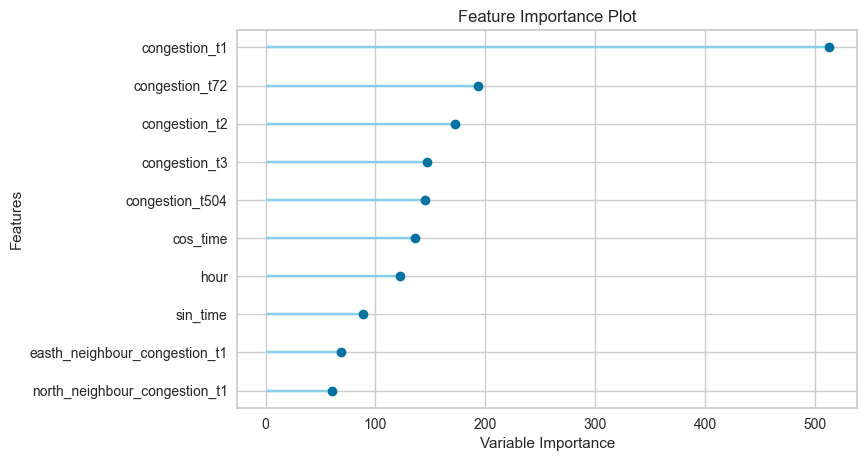

In [108]:
plot_model(lgbm, plot = 'feature')

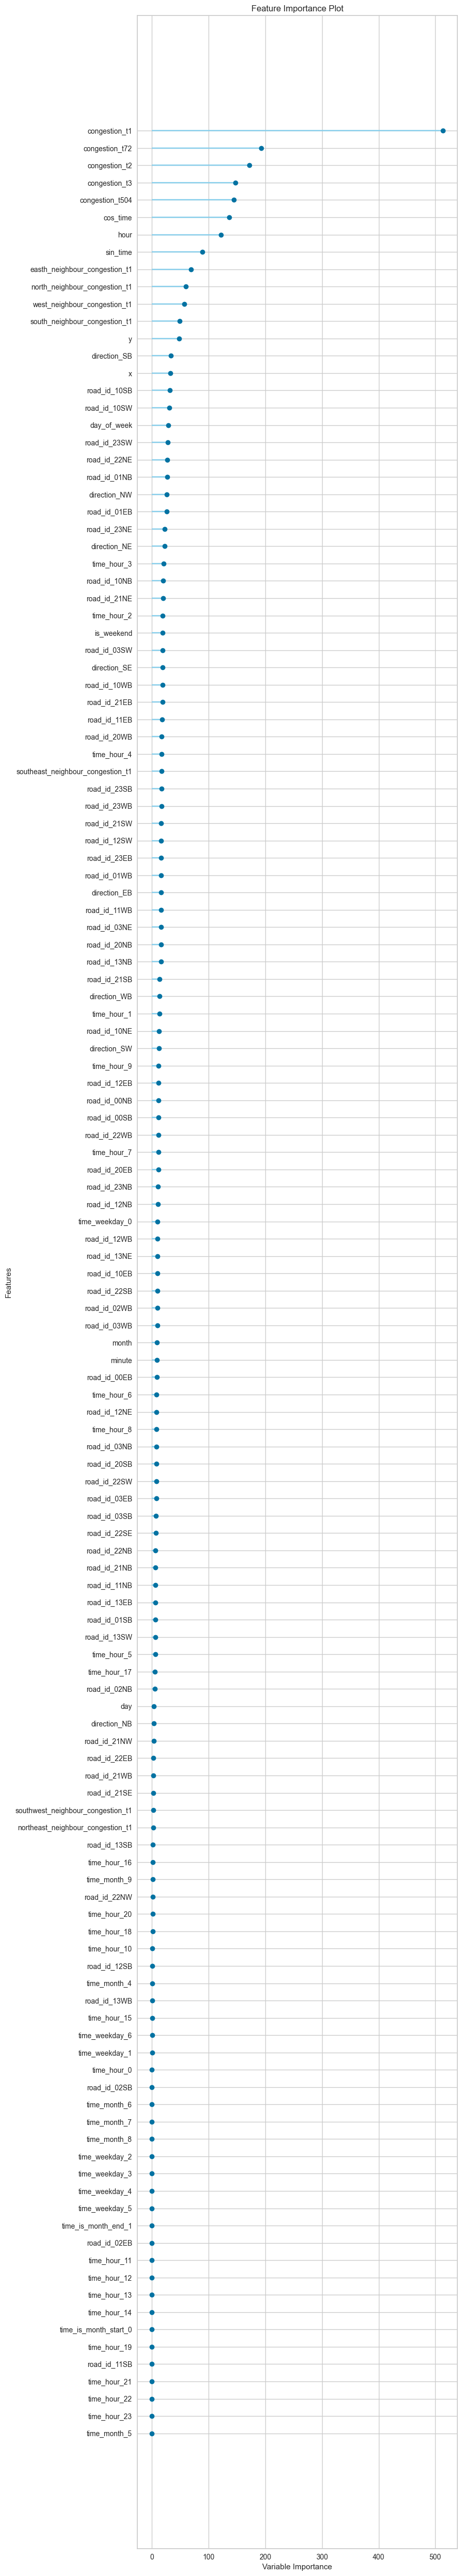

In [123]:
plot_model(lgbm, plot = 'feature_all')

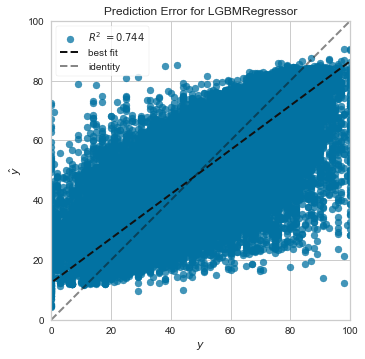

In [115]:
plot_model(lgbm, plot = 'error')

In [ ]:
tuned_lgbm = tune_model(lgbm)

In [106]:
tuned_lgbm

LGBMRegressor(bagging_fraction=0.6, bagging_freq=2, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, device='gpu',
              feature_fraction=0.4, importance_type='split', learning_rate=0.1,
              max_depth=-1, min_child_samples=41, min_child_weight=0.001,
              min_split_gain=0.9, n_estimators=260, n_jobs=-1, num_leaves=70,
              objective=None, random_state=123, reg_alpha=2, reg_lambda=3,
              silent='warn', subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

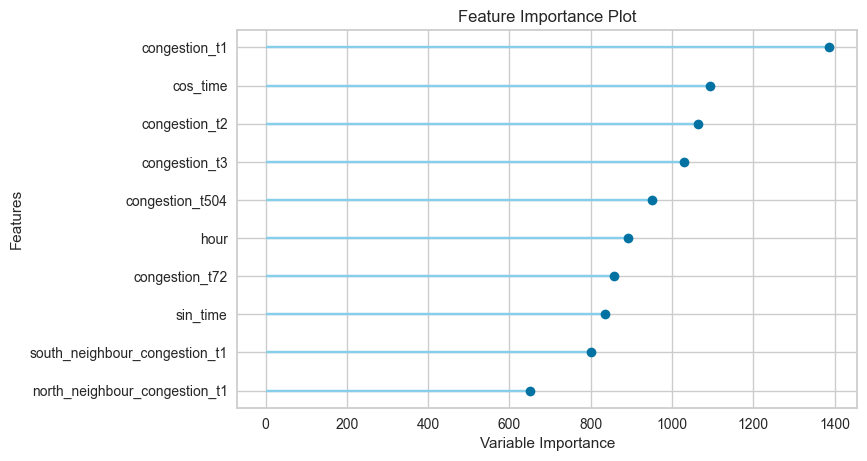

In [109]:
plot_model(tuned_lgbm, plot = 'feature')

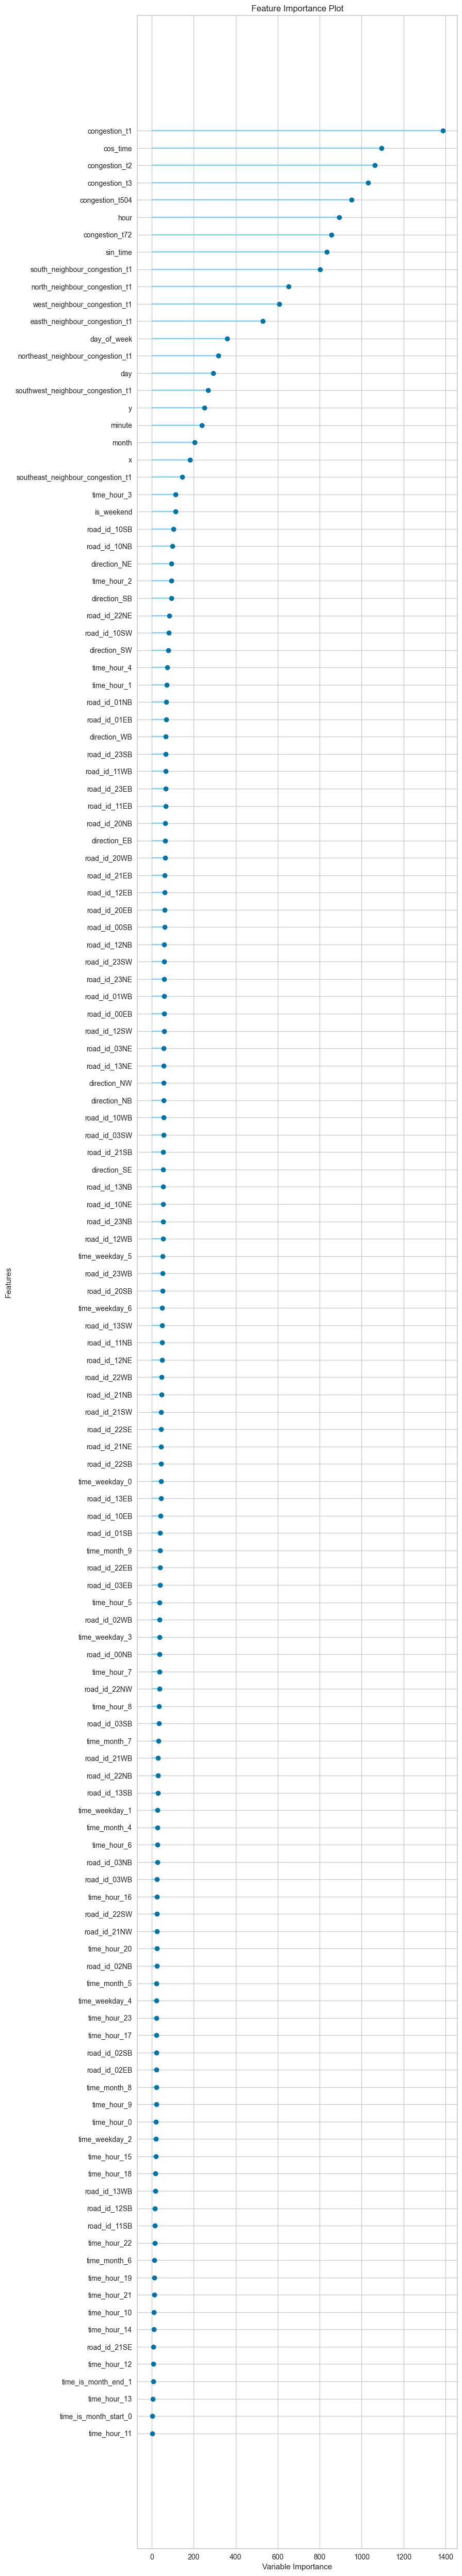

In [122]:
plot_model(tuned_lgbm, plot = 'feature_all')

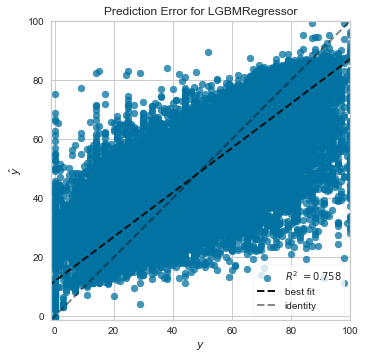

In [116]:
plot_model(tuned_lgbm, plot = 'error')

In [117]:
test_predictions = generate_predictions(tuned_lgbm, train_data, test_data)
test_predictions.to_csv("Submissions/pycaret_tuned_lightgbm_road_features.csv",  index_label = 'row_id')

Predicting timestamp: 1991-09-30T12:00:00.000000000
Predicting timestamp: 1991-09-30T12:20:00.000000000
Predicting timestamp: 1991-09-30T12:40:00.000000000
Predicting timestamp: 1991-09-30T13:00:00.000000000
Predicting timestamp: 1991-09-30T13:20:00.000000000
Predicting timestamp: 1991-09-30T13:40:00.000000000
Predicting timestamp: 1991-09-30T14:00:00.000000000
Predicting timestamp: 1991-09-30T14:20:00.000000000
Predicting timestamp: 1991-09-30T14:40:00.000000000
Predicting timestamp: 1991-09-30T15:00:00.000000000
Predicting timestamp: 1991-09-30T15:20:00.000000000
Predicting timestamp: 1991-09-30T15:40:00.000000000
Predicting timestamp: 1991-09-30T16:00:00.000000000
Predicting timestamp: 1991-09-30T16:20:00.000000000
Predicting timestamp: 1991-09-30T16:40:00.000000000
Predicting timestamp: 1991-09-30T17:00:00.000000000
Predicting timestamp: 1991-09-30T17:20:00.000000000
Predicting timestamp: 1991-09-30T17:40:00.000000000
Predicting timestamp: 1991-09-30T18:00:00.000000000
Predicting t

In [119]:
temp = test_predictions.sort_values(['time', 'x', 'y', 'direction'])
temp.index = test.index
temp['congestion'].to_csv("Submissions/pycaret_tuned_lightgbm_road_features.csv",  index_label = 'row_id')

In [125]:
final_model = finalize_model(tuned_lgbm)
test_predictions_final_model = generate_predictions(final_model, train_data, test_data)
temp = test_predictions_final_model.sort_values(['time', 'x', 'y', 'direction'])
temp.index = test.index
temp['congestion'].to_csv("Submissions/pycaret_tuned_finalized_lightgbm_road_features.csv",  index_label = 'row_id')

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 